#### GAMLSS modelling of tree taper

In [24]:
library(mgcv)
library(dplyr)
library(ggplot2)
library(Metrics)
library(gratia)
library(rsample)
library(parallel)
library(gamlss)
library(gamlss.add)
library(ggpubr)
library(ggplot2)
library(car)

In [25]:
theme_consistent <- function(){
  theme_bw()+
    theme(text = element_text(size=10),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          strip.background = element_blank(),
          axis.text.x = element_text(color="black"),
          axis.text.y = element_text(color="black"),
          axis.ticks = element_line(color = "black",linewidth=0.2),
          panel.border = element_rect(color = "black", fill = NA)
    ) 
}

In [26]:
options(mc.cores = parallel::detectCores())

In [27]:
dados <- read.csv('test.csv')

In [28]:
dados$id <- seq(1,length(dados$d),by=1)
dados$loghih <- log(dados$hih+1)
volumes <- aggregate(dados$vi,by=list(dados$ID),FUN=sum)
diameters <- aggregate(dados$d,by=list(dados$ID),FUN=mean)
heights <- aggregate(dados$h,by=list(dados$ID),FUN=mean)


In [29]:
total_vols <- cbind(v=volumes,d =diameters,h =heights)

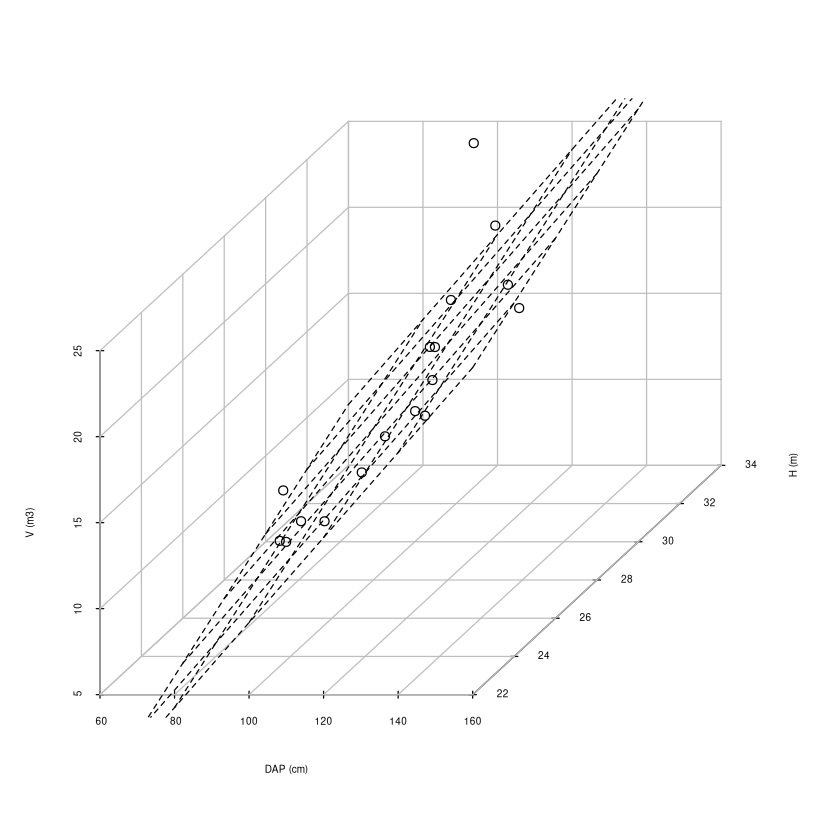

In [30]:
library(scatterplot3d)
source('https://www.sthda.com/sthda/RDoc/functions/addgrids3d.r')
s3d <-scatterplot3d(total_vols$d.x, 
              total_vols$h.x, 
              total_vols$v.x, 
              xlab = "DAP (cm)", 
              ylab = "H (m)", 
              zlab = "V (m3)",
              pch = "",        
              color = "black",
              grid = FALSE, 
              box = FALSE,
              cex.axis=0.5,
              cex.lab = 0.5)
addgrids3d(total_vols$d.x, 
           total_vols$h.x, 
           total_vols$v.x, grid = c("xy", "xz", "yz"))
s3d$points3d(total_vols$d.x, 
             total_vols$h.x, 
             total_vols$v.x, pch = 1)
lm <- lm(total_vols$v.x ~ total_vols$d.x + total_vols$h.x)
s3d$plane3d(lm)# regressao linear simples para demonstrar crescimento na variavel V*


In [31]:
set.seed(412)
train_ratio <- 0.8
ID_arvores <- unique(dados$ID)
train_treeIDs<- sample(ID_arvores, size = round(train_ratio * length(ID_arvores))) #estratificar para manter mesmos IDS
train <- subset(dados, ID %in% train_treeIDs)
test <- subset(dados, !ID %in% train_treeIDs)
train$ID <- as.factor(train$ID)
test$ID <- as.factor(test$ID)

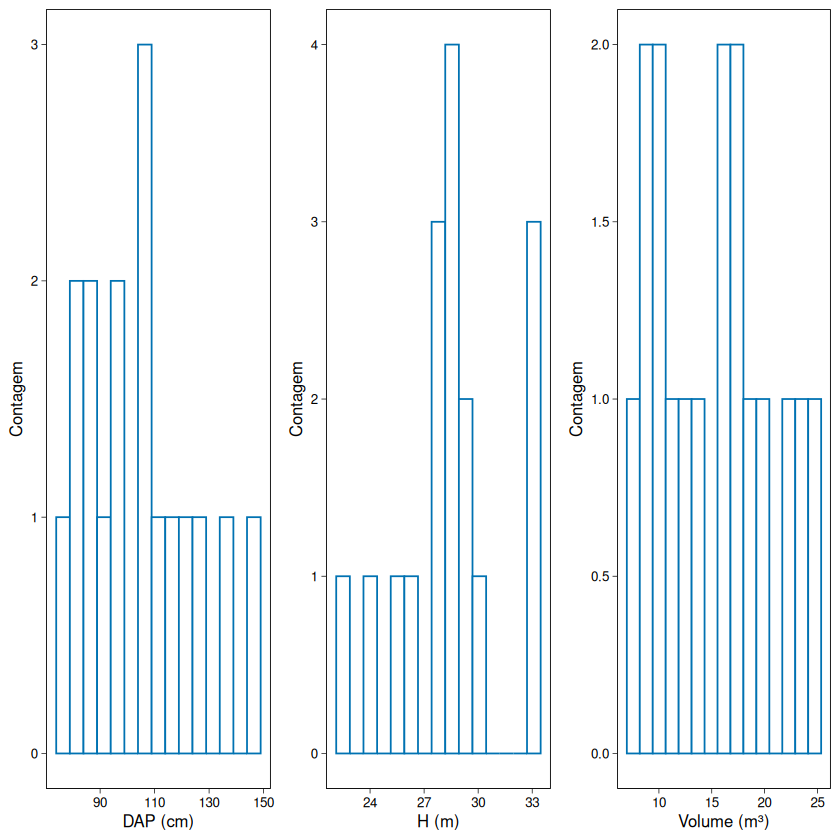

In [32]:
k <- 1 + 3.3 * log2(length(dados))
hist_d <- ggplot(aes(x=d.x),data=total_vols) + geom_histogram(colour = "#0072B2", fill = "white", 
                                             bins = round(k,0)) +
  labs(x='DAP (cm)', y='Contagem') + theme_consistent()

hist_h <- ggplot(aes(x=h.x),data=total_vols) + geom_histogram(colour = "#0072B2", fill = "white", 
                                             bins =  round(k,0)) +
  labs(x='H (m)', y='Contagem') + theme_consistent()
hist_v <- ggplot(aes(x=v.x),data=total_vols) + geom_histogram(colour = "#0072B2", fill = "white", 
                                                              bins =  round(k,0)) +
  labs(x='Volume (m³)', y='Contagem') + theme_consistent()

ggarrange(hist_d,hist_h,hist_v,ncol = 3)

In [33]:
library(e1071)
skewness(total_vols$d.x)
skewness(total_vols$h.x)
skewness(total_vols$v.x)

kurtosis(total_vols$d.x)
kurtosis(total_vols$h.x)
kurtosis(total_vols$v.x)

[1] 0.4860679

[1] -0.1138974

[1] 0.164099

[1] -0.8176657

[1] -0.4612459

[1] -1.377975

In [34]:
lm2 <- gamlss(di ~ 1,sigma.formula = ~  1,nu.formula = ~  1,data=train,family=BCT)
step_mu <- gamlss::stepGAIC(lm2, scope = list(lower = ~1, upper =~ di ~ d + h + log(hih+1) + hi),direction = "forward")
summary(step_mu)

GAMLSS-RS iteration 1: Global Deviance = 684.9019 
GAMLSS-RS iteration 2: Global Deviance = 683.7343 
GAMLSS-RS iteration 3: Global Deviance = 683.6777 
GAMLSS-RS iteration 4: Global Deviance = 683.675 
GAMLSS-RS iteration 5: Global Deviance = 683.6748 
Distribution parameter:  mu 
Start:  AIC= 691.67 
 di ~ 1 

               Df    AIC
+ d             1 626.78
+ hi            1 665.31
+ log(hih + 1)  1 667.57
+ h             1 688.68
<none>            691.67

Step:  AIC= 626.78 
 di ~ d 

               Df    AIC
+ hi            1 538.92
+ log(hih + 1)  1 541.81
+ h             1 626.58
<none>            626.78

Step:  AIC= 538.92 
 di ~ d + hi 

               Df    AIC
<none>            538.92
+ h             1 540.05
+ log(hih + 1)  1 540.55
******************************************************************
Family:  c("BCT", "Box-Cox t") 

Call:  gamlss(formula = di ~ d + hi, sigma.formula = ~1, nu.formula = ~1,  
    family = BCT, data = train, trace = FALSE) 

Fitting method: RS(

In [35]:
lm2 <- gamlss(di ~ d + hi,sigma.formula = ~  1,nu.formula = ~  1,data=train,family=BCCG)
step_sigma <- gamlss::stepGAIC(lm2, what="sigma", scope = list(lower = ~1, upper =~ di ~ d + h + hi),direction = "forward")
summary(step_sigma)

GAMLSS-RS iteration 1: Global Deviance = 528.2721 
GAMLSS-RS iteration 2: Global Deviance = 527.2747 
GAMLSS-RS iteration 3: Global Deviance = 527.1766 
GAMLSS-RS iteration 4: Global Deviance = 527.167 
GAMLSS-RS iteration 5: Global Deviance = 527.166 
GAMLSS-RS iteration 6: Global Deviance = 527.1659 
Distribution parameter:  sigma 
Start:  AIC= 537.17 
 ~1 

       Df    AIC
+ hi    1 534.25
<none>    537.17
+ d     1 537.20
+ h     1 539.06

Step:  AIC= 534.25 
 ~hi 

       Df    AIC
<none>    534.25
+ d     1 534.48
+ h     1 536.25
******************************************************************
Family:  c("BCCG", "Box-Cox-Cole-Green") 

Call:  gamlss(formula = di ~ d + hi, sigma.formula = ~hi,  
    nu.formula = ~1, family = BCCG, data = train, trace = FALSE) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  identity
Mu Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 18.04792    4.10686

In [36]:
lm2 <- gamlss(di ~ d + hi,sigma.formula = ~  hi,nu.formula = ~  1,data=train,family=BCCG)
step_nu <- gamlss::stepGAIC(lm2,what='nu', scope = list(lower = ~1, upper =~ di ~ d + h + log(hih+1) + hi),direction = "forward")
summary(step_nu)

GAMLSS-RS iteration 1: Global Deviance = 523.6319 
GAMLSS-RS iteration 2: Global Deviance = 522.2833 
GAMLSS-RS iteration 3: Global Deviance = 522.2518 
GAMLSS-RS iteration 4: Global Deviance = 522.2503 
GAMLSS-RS iteration 5: Global Deviance = 522.2502 
Distribution parameter:  nu 
Start:  AIC= 534.25 
 ~1 

               Df    AIC
+ h             1 528.72
<none>            534.25
+ d             1 536.05
+ log(hih + 1)  1 536.08
+ hi            1 536.14

Step:  AIC= 528.72 
 ~h 

               Df    AIC
<none>            528.72
+ d             1 529.43
+ log(hih + 1)  1 530.40
+ hi            1 530.50
******************************************************************
Family:  c("BCCG", "Box-Cox-Cole-Green") 

Call:  gamlss(formula = di ~ d + hi, sigma.formula = ~hi,  
    nu.formula = ~h, family = BCCG, data = train, trace = FALSE) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  identity
Mu Coefficients:
            Est

In [37]:
lm2 <- gamlss(di ~ d + hi,
              sigma.formula = ~  hi ,
              nu.formula = ~  h,
              tau.formula = ~ 1,
              data=train,family=BCT)
summary(lm2)
step_tau <- gamlss::stepGAIC(lm2,what='tau', scope = list(lower = ~1, upper =~ di ~ d + h + hi),direction = "forward")

GAMLSS-RS iteration 1: Global Deviance = 518.4332 
GAMLSS-RS iteration 2: Global Deviance = 515.0409 
GAMLSS-RS iteration 3: Global Deviance = 514.8309 
GAMLSS-RS iteration 4: Global Deviance = 514.7282 
GAMLSS-RS iteration 5: Global Deviance = 514.718 
GAMLSS-RS iteration 6: Global Deviance = 514.717 


Warning message in summary.gamlss(lm2):
“summary: vcov has failed, option qr is used instead
”


******************************************************************
Family:  c("BCT", "Box-Cox t") 

Call:  gamlss(formula = di ~ d + hi, sigma.formula = ~hi, nu.formula = ~h,  
    tau.formula = ~1, family = BCT, data = train) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  identity
Mu Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 14.12071    3.00364   4.701 1.13e-05 ***
d            0.76074    0.02665  28.550  < 2e-16 ***
hi          -1.00065    0.05666 -17.660  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

------------------------------------------------------------------
Sigma link function:  log
Sigma Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.765780   0.138239 -20.007   <2e-16 ***
hi           0.019854   0.008087   2.455   0.0163 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

-------------

In [38]:
lm2 <- gamlss(di ~ d + hi,
              sigma.formula = ~  hi,
              nu.formula = ~  h,
              tau.formula = ~ 1,
              data=train,family=BCT)

GAMLSS-RS iteration 1: Global Deviance = 518.4332 
GAMLSS-RS iteration 2: Global Deviance = 515.0409 
GAMLSS-RS iteration 3: Global Deviance = 514.8309 
GAMLSS-RS iteration 4: Global Deviance = 514.7282 
GAMLSS-RS iteration 5: Global Deviance = 514.718 
GAMLSS-RS iteration 6: Global Deviance = 514.717 


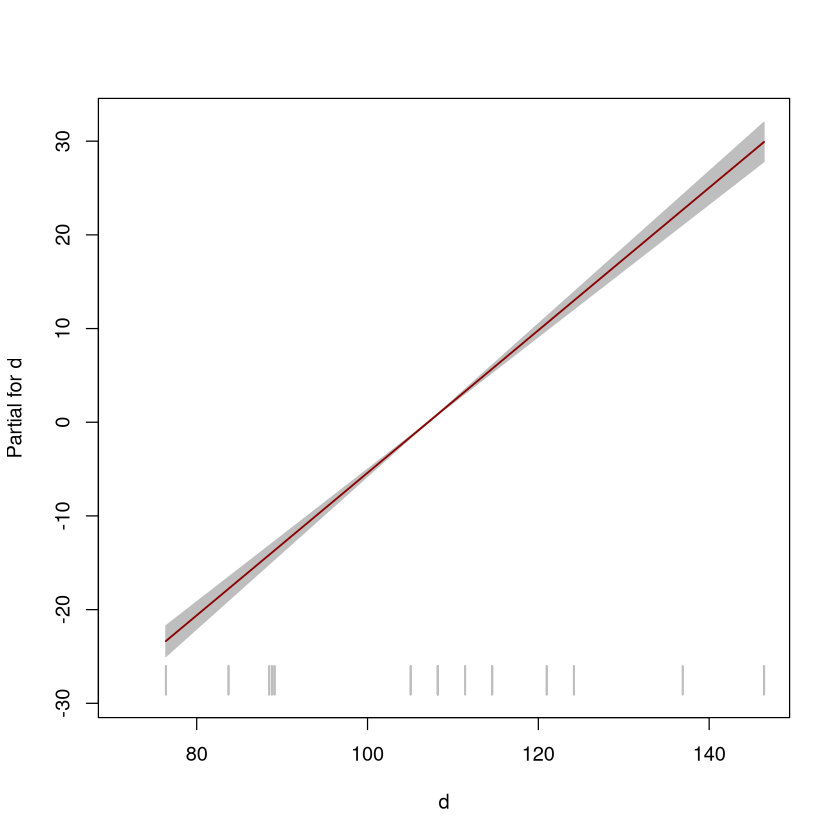

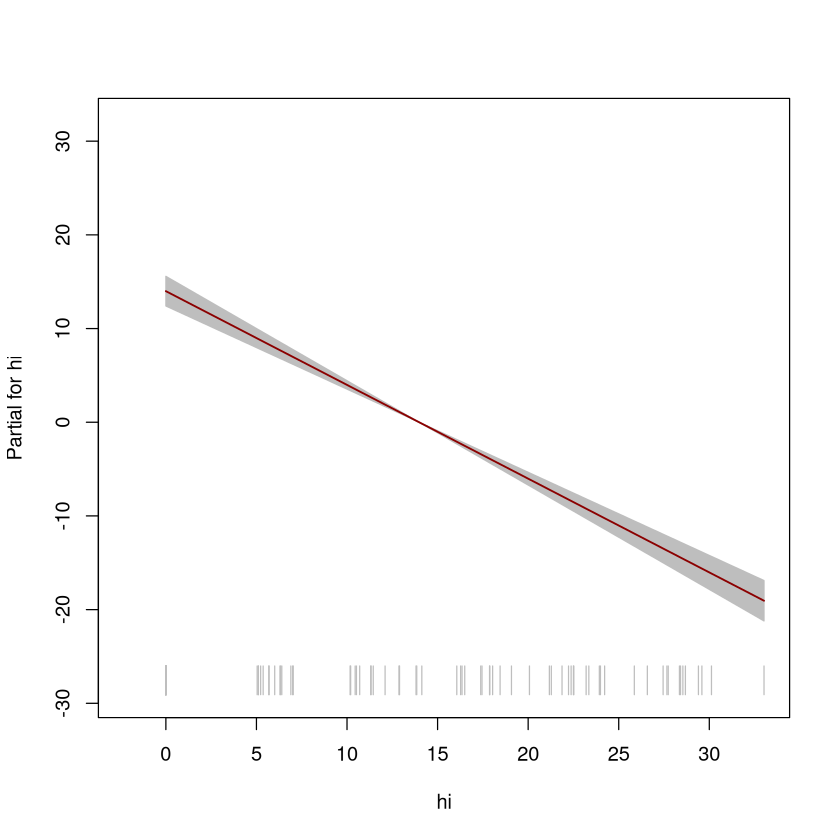

In [39]:
term.plot(lm2,what='mu',rug=TRUE)

******************************************************************
	      Summary of the Quantile Residuals
                           mean   =  -0.04242981 
                       variance   =  1.027465 
               coef. of skewness  =  0.1986623 
               coef. of kurtosis  =  2.678132 
Filliben correlation coefficient  =  0.9946254 
******************************************************************


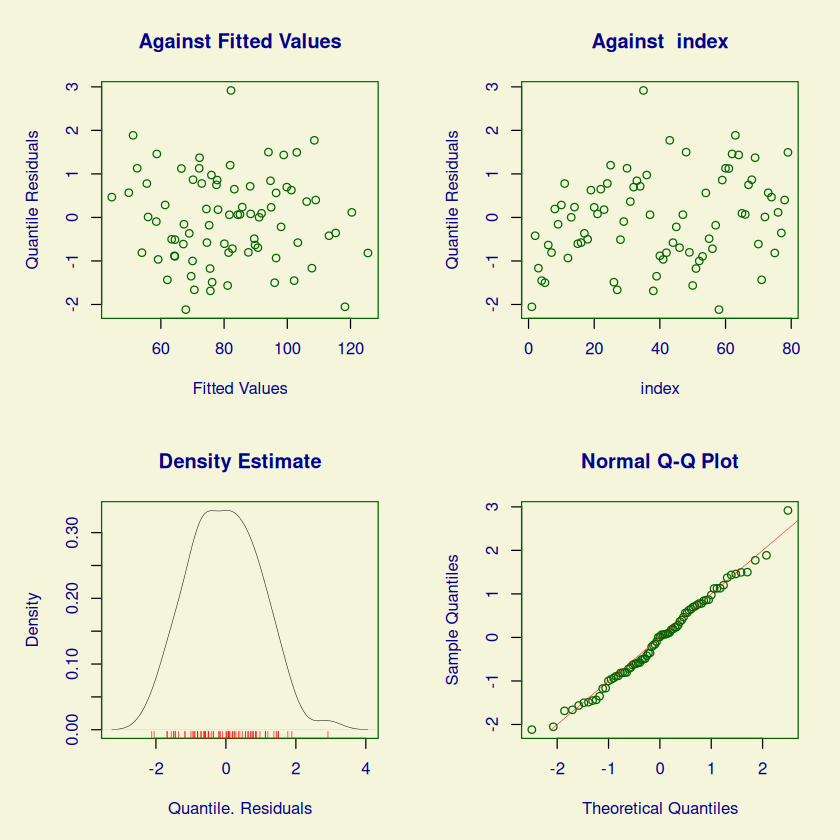

In [40]:
plot(lm2)

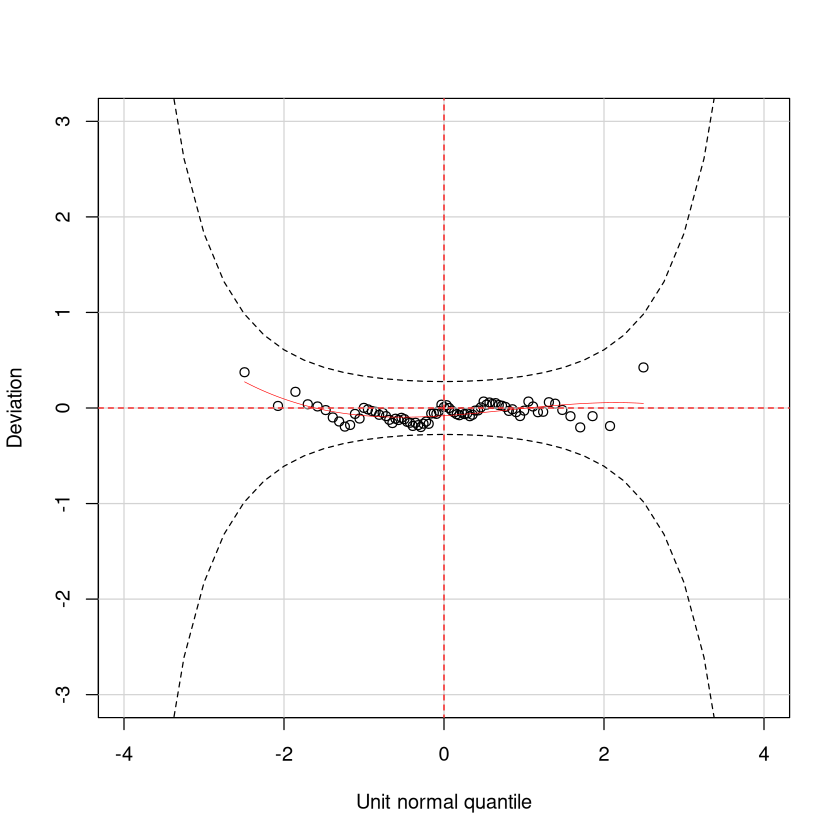

In [41]:
wp(lm2,ylim.all =3,pch=1)

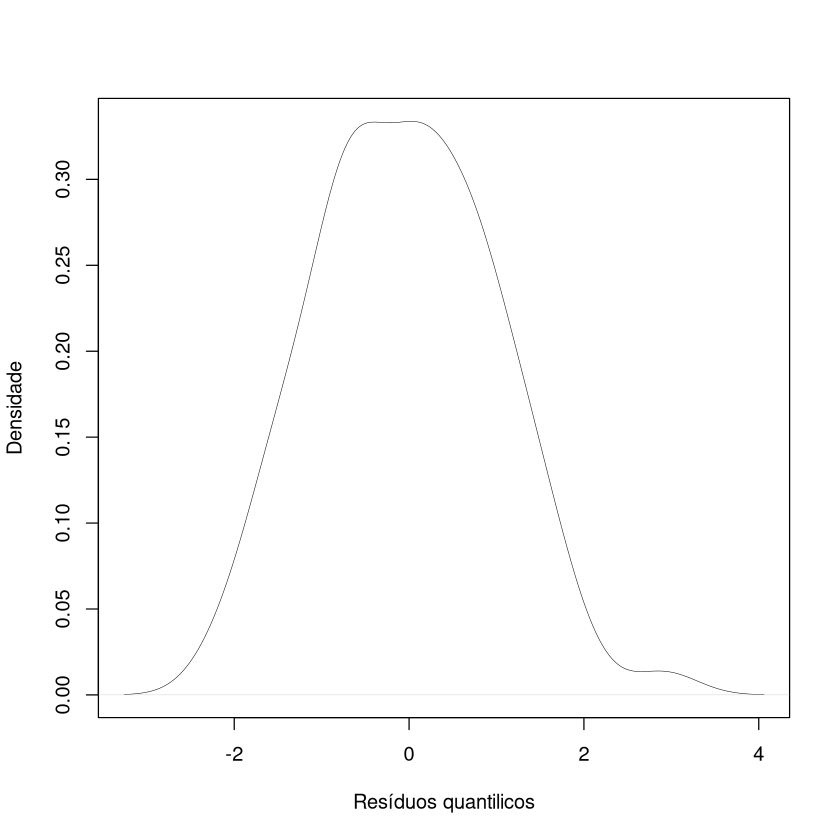

In [42]:
plot(density(resid(lm2)), 
     xlab = "Resíduos quantilicos", 
     ylab = "Densidade", 
     frame.plot = TRUE, 
     col="black", 
     lwd=0.4 ,
     main="")

In [43]:
test$di_pred <- predict(lm2,newdata=test,type="response")
rmse(test$di_pred,test$di) / mean(test$di) * 100

[1] 20.82099

In [44]:
test$resid <- test$di - test$di_pred

In [45]:
f_gamlss <- function(d, hi, h, model) {

  mu_coef <- coef(model, what = "mu") # extrair coeficients 
  
  
  mu <- mu_coef[1] + mu_coef[2] * d + mu_coef[3] * hi # equacao
  di_pred <- mu
  
  return(di_pred)
}

v_gamlss <- function(d, hi,h, model) {
  integrate(f = function(hi) {
  # Calcula o diametro e area transversal e integradesde .1 ate o valor especificado por hi
    di <- f_gamlss(d, hi, h, model)

    (pi / 40000) * di^2
  }, lower = 0.1, upper = hi)$value
}


In [46]:
volumes_test <- aggregate(test$vi,by=list(test$ID),FUN=sum)
diameters_test <- aggregate(test$d,by=list(test$ID),FUN=mean)
heights_test <- aggregate(test$h,by=list(test$ID),FUN=mean)

total_vols_test <- cbind(v=volumes_test,d =diameters_test,h =heights_test)

gamlss.vol <- lapply(1:length(total_vols_test$d.x), function(i) {
  v_gamlss(d = total_vols_test$d.x[i], h = total_vols_test$h.x[i], hi= total_vols_test$h.x[i], model = lm2)
})




gamlss.vol <- unlist(gamlss.vol)
gamlss.vol <- as.data.frame(gamlss.vol)


In [47]:
test_pred <- test %>%
  group_by(ID) %>%
  arrange(hi) %>%
  mutate(
    hi_next = lead(hi),
    di_next = lead(di_pred),
    volume = purrr::map2_dbl(hi, hi_next, ~{
      if (is.na(.y)) return(NA_real_)
      

      di_start <- di_pred[hi == .x]
      di_end   <- di_next[hi == .x]
      
      di_fun <- approxfun(x = c(.x, .y), y = c(di_start, di_end))
      
      integrate(function(h) (pi / 40000) * di_fun(h)^2, lower = .x, upper = .y)$value
    })
  )
test_pred[is.na(test_pred)] <- 0

In [48]:
test_pred$resid = (test_pred$vi - test_pred$volume)
test_pred$resid_di = (test_pred$di - test_pred$di_pred)

In [49]:
mod0 <- lm(test_pred$di ~ test_pred$di_pred)
summary(mod0)


Call:
lm(formula = test_pred$di ~ test_pred$di_pred)

Residuals:
    Min      1Q  Median      3Q     Max 
-16.677  -7.779  -2.997   8.726  18.635 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -11.163     16.114  -0.693    0.497    
test_pred$di_pred    1.336      0.232   5.758 1.86e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.8 on 18 degrees of freedom
Multiple R-squared:  0.6482,	Adjusted R-squared:  0.6286 
F-statistic: 33.16 on 1 and 18 DF,  p-value: 1.855e-05


In [50]:
mod1 <- lm(test_pred$vi ~ test_pred$volume)
summary(mod1)


Call:
lm(formula = test_pred$vi ~ test_pred$volume)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.1334 -0.5534 -0.1580  0.4684  1.3718 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -0.1569     0.3764  -0.417    0.682    
test_pred$volume   1.4910     0.1905   7.826 3.35e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7714 on 18 degrees of freedom
Multiple R-squared:  0.7729,	Adjusted R-squared:  0.7603 
F-statistic: 61.25 on 1 and 18 DF,  p-value: 3.346e-07


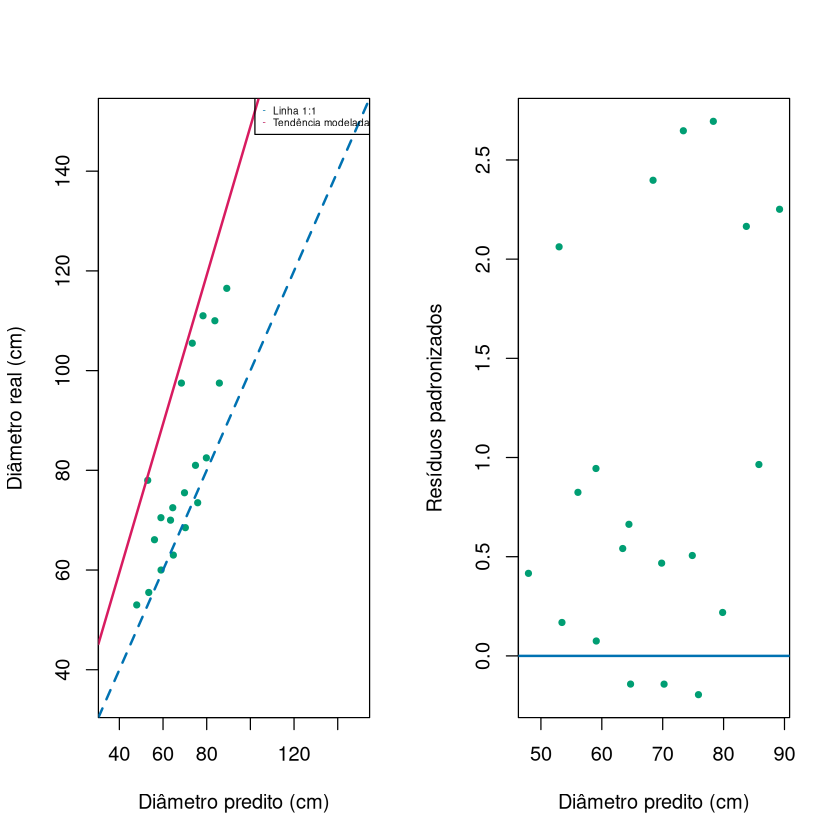

In [51]:
par(mfrow=c(1,2))
plot(test_pred$di_pred, test_pred$di,
     xlab = "Diâmetro predito (cm)",
     ylab = "Diâmetro real (cm)",
     pch = 20, col = "#009E73",
     xlim=c(35,150),ylim=c(35,150))
abline(mod1, col = "#D81B60", lwd = 2)
abline(0, 1, col = "#0072B2", lwd = 2,lty=2)
legend("topright", legend = c("Linha 1:1","Tendência modelada"), pch = c("-","-"), col = c("#0072B2",'#D81B60'),cex=0.5)
plot(test_pred$di_pred, test_pred$resid_di / sd(test_pred$resid_di),
     xlab = "Diâmetro predito (cm)",
     ylab = "Resíduos padronizados",
     pch = 20, col = "#009E73")
abline(0, 0, col = "#0072B2", lwd = 2)

In [53]:
mod3 <- lm(total_vols_test$v.x ~ gamlss.vol$gamlss.vol)
summary(mod3)


Call:
lm(formula = total_vols_test$v.x ~ gamlss.vol$gamlss.vol)

Residuals:
      1       2       3 
 2.2436  0.7219 -2.9655 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)
(Intercept)           -15.3523    11.3172  -1.357    0.404
gamlss.vol$gamlss.vol   2.7258     0.9529   2.860    0.214

Residual standard error: 3.788 on 1 degrees of freedom
Multiple R-squared:  0.8911,	Adjusted R-squared:  0.7822 
F-statistic: 8.182 on 1 and 1 DF,  p-value: 0.2141


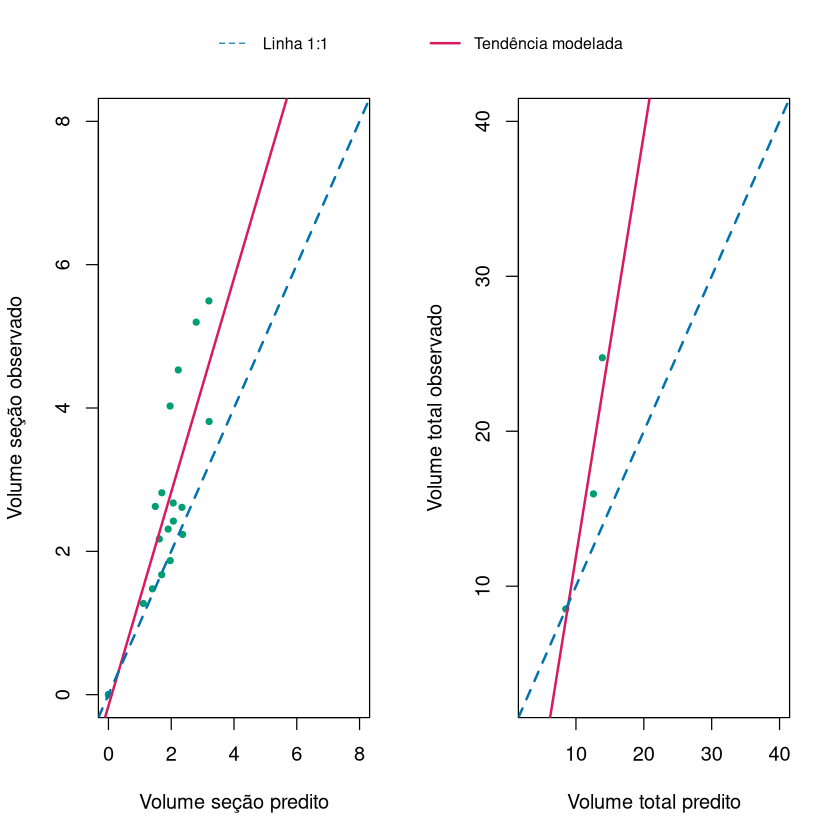

In [55]:
par(mfrow=c(1,2))
plot(test_pred$volume, test_pred$vi,
     xlab = "Volume seção predito",
     ylab = "Volume seção observado",
     main = "",
     pch = 20, col = "#009E73",
     xlim=c(0,8),
     ylim=c(0,8))
abline(mod1, col = "#D81B60", lwd = 2)
abline(0, 1, col = "#0072B2", lwd = 2,lty=2)
plot(gamlss.vol$gamlss.vol, total_vols_test$v.x ,
     xlab = "Volume total predito",
     ylab = "Volume total observado",
     main = "",
     pch = 20, col = "#009E73",
     xlim=c(3,40),
     ylim=c(3,40))
abline(mod3, col = "#D81B60", lwd = 2)
abline(0, 1, col = "#0072B2", lwd = 2,lty=2)

par(fig = c(0, 1, 0, 1), new = TRUE, mar = c(0, 0, 1, 0))
plot(0, 0, type = "n", axes = FALSE, xlab = "", ylab = "")
legend("top", horiz = TRUE, bty = "n",
       legend = c("Linha 1:1", "Tendência modelada"),
       col = c("#0072B2", "#D81B60"),
       lty = c(2, 1), lwd = c(1, 2),
       cex = 0.8, inset = 0)